In [19]:
from model import NBAModel, NBAConfig
from torch import device as torch_device, load as torch_load, int32, Tensor, bfloat16
import matplotlib.pyplot as plt

device = torch_device("cpu") 
num_age_tokens=32
num_player_tokens=5141
num_net_score_tokens=41
players_per_team=8

model_config = NBAConfig(
    players_per_team=players_per_team,
    player_tokens=num_player_tokens+2,
    age_tokens=num_age_tokens+2,
    num_labels=num_net_score_tokens+2,
    n_layer=4,
    n_head=4,
    n_embd=1024,
    dropout=0.0,
    bias=False,
    dtype=bfloat16,
    seed=29,
)

model = NBAModel(model_config).to(device)
state_dict = torch_load('weights.pt', map_location='cpu')
model.load_state_dict(state_dict)
model = model.eval()

Home team win probability: 0.65


<BarContainer object of 40 artists>

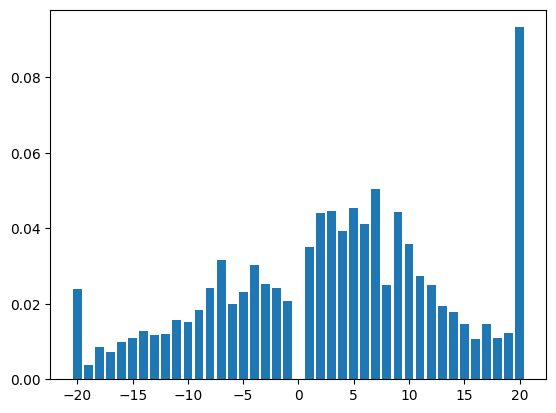

In [21]:
# Change player and age tokens here!
# You can find these values in player_tokens.csv and age_tokens.csv
# You must provide exactly 8 player tokens and 8 age tokens for each team.

# Denver Nuggets first game of 2023-24 season roster
home_player_tokens = [5035, 4298, 4626, 4690, 4750, 5082, 4286, 4311]
home_age_tokens = [14, 16, 13, 12, 10, 19, 8, 8]

# Uncomment to take Jokic off team, replace with Peyton Watson
# home_player_tokens = [4331, 4298, 4626, 4690, 4750, 5082, 4286, 4311]
# home_age_tokens = [6, 16, 13, 12, 10, 19, 8, 8]

# Boston Celtics final game of 2023-24 season roster
away_player_tokens = [5042, 5039, 5027, 4981, 4972, 5004, 4416, 4983]
away_age_tokens = [11, 12, 19, 14, 23, 11, 13, 13]

# Uncomment to take Tatum off team, replace with Pritchard
# away_player_tokens = [4999, 5039, 5027, 4981, 4972, 5004, 4416, 4983]
# away_age_tokens = [11, 12, 19, 14, 23, 11, 13, 13]

# The model usually gives the home team a bump in win probability.
# Change this to "True" to swap home and away teams.
swap_home_away = False
if swap_home_away:
    home_player_tokens, away_player_tokens = away_player_tokens, home_player_tokens
    home_age_tokens, away_age_tokens = away_age_tokens, home_age_tokens

assert len(home_player_tokens) == players_per_team
assert len(home_age_tokens) == players_per_team
assert len(away_player_tokens) == players_per_team
assert len(away_age_tokens) == players_per_team

batch = {
    'home_player_tokens': Tensor([num_player_tokens+1] + home_player_tokens).to(dtype=int32).unsqueeze(0),
    'home_age_tokens': Tensor([num_age_tokens+1] + home_age_tokens).to(dtype=int32).unsqueeze(0),
    'away_player_tokens': Tensor(away_player_tokens).to(dtype=int32).unsqueeze(0),
    'away_age_tokens': Tensor(away_age_tokens).to(dtype=int32).unsqueeze(0),
}

for key, value in batch.items():
    if hasattr(value, 'to'):
        batch[key] = value.to(device)

output, _ = model(**batch)
output = output.squeeze().softmax(dim=0)

probs = {}
loss_prob = 0
win_prob = 0

first = True
for i, token in enumerate(output):
    if first:
        first = False
        continue

    if i-21 < 0:
        loss_prob += token.item()
    elif i-21 > 0 and i-21 < 21:
        win_prob += token.item()

    probs[i-21] = token.item()

del probs[0]
del probs[21]

print(f"Home team win probability: {win_prob:.2f}")

plt.bar(probs.keys(), probs.values())